In [309]:
import pandas as pd
import matplotlib.pyplot as plt

scores_path = '/home/nlyaly/projects/lm-evaluation-harness/results/moe/dfurman__Mixtral-8x7B-Instruct-v0.1/mrpc/score_per_layer.scv'
htrace_path = '/home/nlyaly/projects/lm-evaluation-harness/results/moe/dfurman__Mixtral-8x7B-Instruct-v0.1/mrpc/max_per_layer.csv'
# df = pd.read_csv(scores_path)
# scores = torch.Tensor(df.iloc[:, 1:].values)
df = pd.read_csv(htrace_path)
htraces = torch.Tensor(df.iloc[:, 1:].values)
# df/31#.iloc[:, 1:].plot()
# df = pd.read_csv(rates_path)
# df.iloc[:, 1:].plot(title='Hit rate on MRPC')


Text(0.5, 1.0, 'Sensitivity (Averaged maximum) of layers')

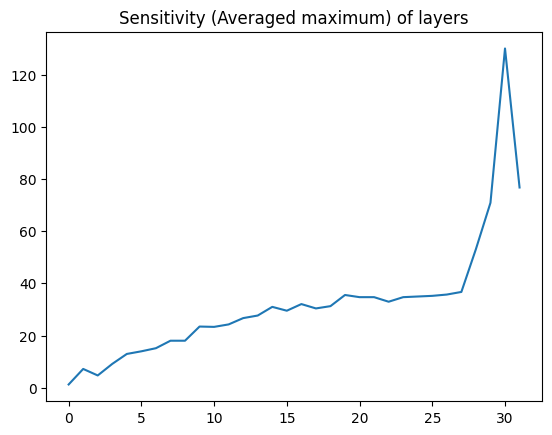

In [310]:
plt.plot(htraces)
plt.title("Sensitivity (Averaged maximum) of layers")

Text(0.5, 1.0, 'Importance (Alpha Score) of 8 experts per layer')

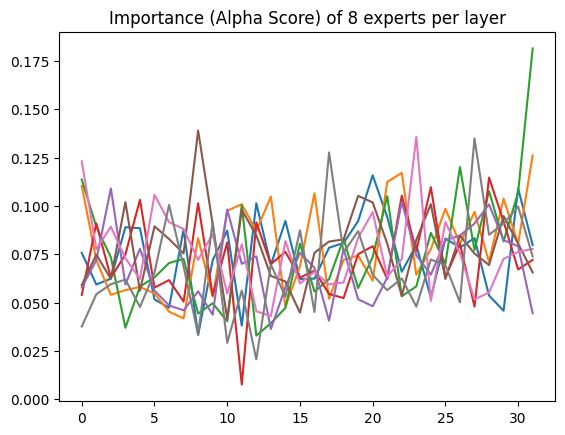

In [311]:
plt.plot(scores)
plt.title("Importance (Alpha Score) of 8 experts per layer")

Text(0.5, 1.0, 'Combined metric for all experts')

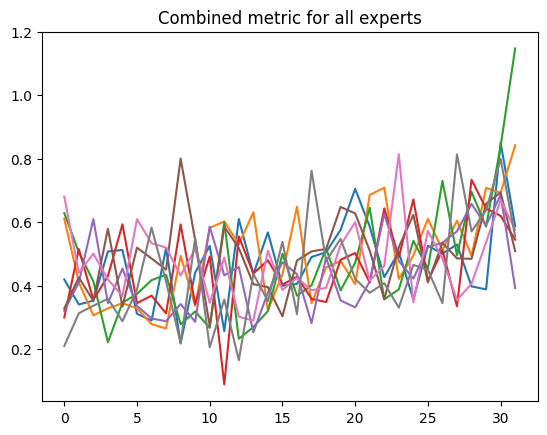

In [322]:
norm_scores = scores / torch.max(scores)
htraces = htraces / torch.max(htraces)
shape = scores.shape
not_clipped_metric = 0.25 * htraces + norm_scores
# TODO: select proportionally number of experts
# not_clipped_metric = htraces.expand(shape)
plt.plot(not_clipped_metric)
plt.title("Combined metric for all experts")

Text(0.5, 1.0, 'With clipped top-2 experts')

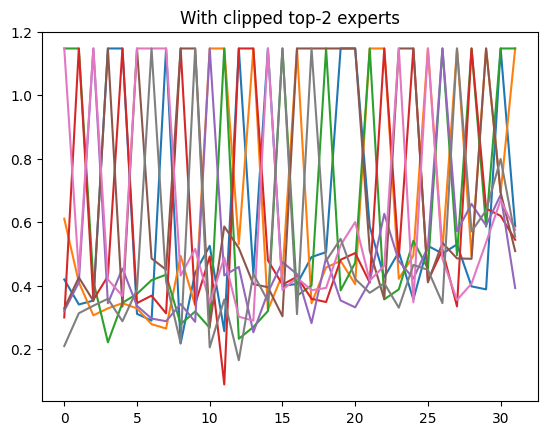

In [326]:
min_num_experts_per_layer = 2
max_metric = not_clipped_metric.max().item()
# shape = not_clipped_metric.shape
values, indices = torch.topk(not_clipped_metric, k=min_num_experts_per_layer)
# not_topk_indices = torch.ones(shape).scatter(1, indices, 0).nonzero(as_tuple=True)
# TODO: not valid after reshape. still 8 experts, but 2 different experts on each layer are disabled
# to_draw = not_clipped_metric[not_topk_indices].reshape(32,6)
metric = not_clipped_metric.scatter(1, indices, max_metric)
# plt.plot(to_draw)
# plt.title("Without top-2 experts")
plt.plot(metric)
plt.title("With clipped top-2 experts")

Text(0.5, 1.0, 'Active expert per layer')

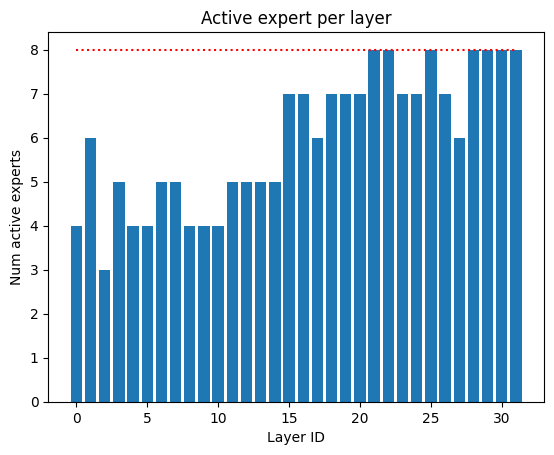

In [330]:
ratio = 2/8
num_values = metric.numel()
border_idx = int(num_values * ratio)
threshold = metric.reshape([-1, 1]).sort(dim=0)[0][border_idx]
# Specifically uint8 mask for Layer4Bit gate
pruning_masks = torch.where(metric>=threshold, torch.ByteTensor([1]), torch.ByteTensor([0]))
# pruning_masks = torch.where(scores>=threshold, 1, 0)

fig, ax = plt.subplots(label='Number of active experts per layer')
ax.bar(x=list(range(32)), height=pruning_masks.sum(dim=1))
ax.plot(torch.ones_like(pruning_masks).sum(dim=1), color='red', linestyle='dotted')
plt.xlabel("Layer ID")
plt.ylabel("Num active experts")
plt.title("Active expert per layer")
